# Hemisphere Analysis

This notebook exemplifies how to use [SNT](https://imagej.net/SNT) to quantify ipsilater/contralateral projection patterns of [MouseLight](http://ml-neuronbrowser.janelia.org/) data.

## Before Starting

1. Ensure you have followed the [detailed instructions](./README.md) on how to set up your environment
2. Ensure you have linked your local Fiji installation to this notebook as detailed in [Overview](1_overview.ipynb)

Scripting documentation is available at https://imagej.net/SNT/Scripting, latest SNT API at https://morphonets.github.io/SNT.

## Setup
As usual, we 1) initialize Fiji with GUI support; 2) import all relevant python modules; and 3) import all relevant SNT classes:

In [1]:
import ijfinder
import imagej
import os

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, mode='interactive')
else:
    print("Cannot proceed: Fiji not found!")

from scyjava import jimport

# sc.fiji.snt
Tree = jimport('sc.fiji.snt.Tree')
# sc.fiji.snt.io
MouseLightLoader = jimport('sc.fiji.snt.io.MouseLightLoader')
# sc.fiji.snt.analisis
TreeStatistics = jimport('sc.fiji.snt.analysis.TreeStatistics')
# sc.fiji.snt.annotation
AllenUtils = jimport('sc.fiji.snt.annotation.AllenUtils')

## Load data

Let's retrieve a cell from the primary motor cortex (MOp) and extract its axon:

In [2]:
loader = MouseLightLoader("AA0876")
if not loader.isDatabaseAvailable():
    print("Could not connect to ML database", "Error")
if not loader.idExists():
    print("Somehow the specified id was not found", "Error")
axon = loader.getTree('axon')

## Does the axon have contralateral projections?

Let's answer this programatically. In the MouseLight database, the straight mid-sagittal plane is defined by an X coordinate (note that this diverges from the original CCF orientation). Thus, we can get immediate insights into ipsilateral/contralateral hemisphere distributions by looking at the distribuition of X coordinates of reconstruction nodes (see [Overview](1_overview.ipynb) for TreeStatistics/NodeStatistics details):

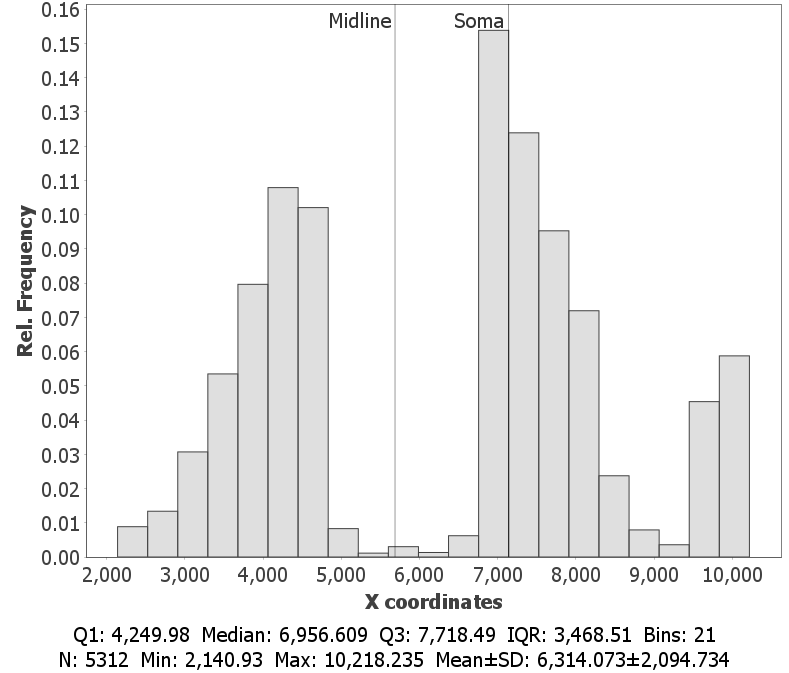

In [3]:
tree_stats = TreeStatistics(axon)
hist = tree_stats.getNodeStatistics().getHistogram("x coordinates")
hist.annotateXline(AllenUtils.brainCenter().getX(), "Midline")
hist.annotateXline(axon.getRoot().getX(), "Soma")
hist.setFontSize(20)
hist.show()

# from IPython.display import Image, display
# display(Image(filename=r"./images/AA0876-hist-xcoords.png",  width=500))

So now we know that this neuron (with soma in the right hemisphere) has both ipsilateral and contraleral projections. This is corroborated by looking at e.g., end-points:

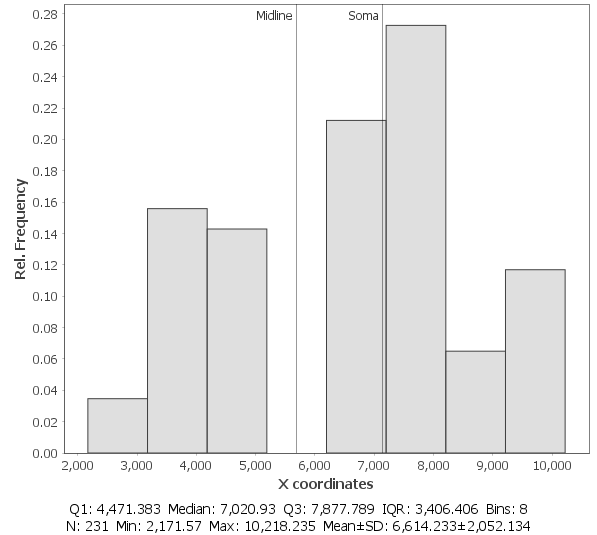

In [4]:
hist = tree_stats.getNodeStatistics("tips").getHistogram("x coordinates")
hist.annotateXline(AllenUtils.brainCenter().getX(), "Midline")
hist.annotateXline(axon.getRoot().getX(), "Soma")
hist.show()

# from IPython.display import Image, display
# display(Image(filename=r"./images/AA0876-hist-xcoords-tips.png",  width=500))

NB: In SNT, neuropil annotations are by default generic to accomodate different species. Since we are using mouse data registered to the Allen CCF, use the `AllenUtils` class to access CCF details.

## Does the axon target the same brain area evenly across hemispheres?

To answer this it is convenient to first tag all the nodes in the reconstruction with 'left', 'right' hemisphere tags.

In [5]:
AllenUtils.assignHemisphereTags(axon) # tag each node with 'left'/'right' labels

Now when we query TreeStatistics to obtain annotated lengths (i.e., the amount of axonal cable associated with the brain areas inervated by the axon), we can split results by hemisphere.
To simplify things, we are going to parse only brain areas of "mid-level ontology" (i.e., those at mid-depth in the CCF ontology, that, as of this writing, has a maximum depth of 10):

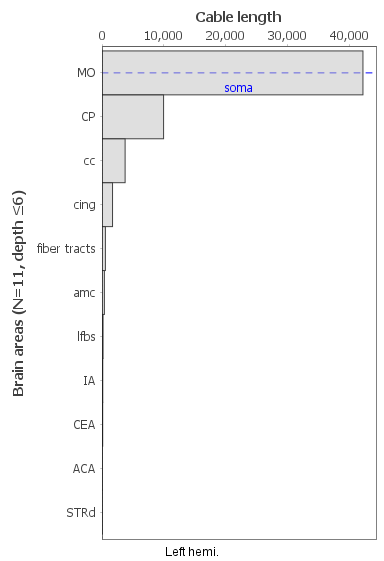

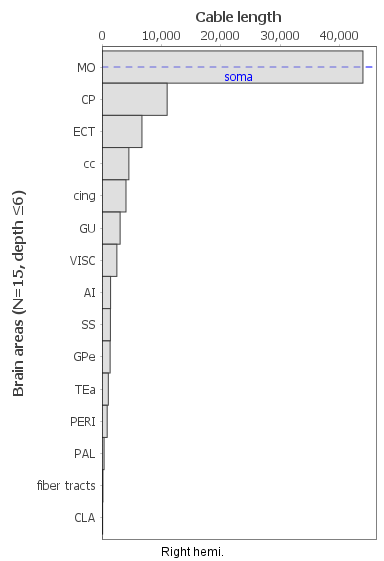

In [6]:
# define a function that higlights the soma compartment in a histogram
def annotate_soma(histogram, ontology_depth):
    global loader, depth
    soma_compartment = loader.getSomaCompartment()
    if soma_compartment.getOntologyDepth() > ontology_depth:
        ancestor_depth = ontology_depth - soma_compartment.getOntologyDepth()
        soma_compartment = soma_compartment.getAncestor(ancestor_depth)
    histogram.annotateCategory(soma_compartment.acronym(), "soma")

depth = 6
hist = tree_stats.getAnnotatedLengthHistogram(depth, "left")
annotate_soma(hist, depth)
hist.show()

# from IPython.display import Image, display
# display(Image(filename=r"./images/AA0876-annotated-length-hist-left.png",  width=500))

hist = tree_stats.getAnnotatedLengthHistogram(depth, "right")
annotate_soma(hist, depth)
hist.show()

# from IPython.display import Image, display
# display(Image(filename=r"./images/AA0876-annotated-length-hist-right.png",  width=500))

And voilá, now we can look for biases in the distribuitons between hemispheres. But looking at the data in this format can be rather cumbersome.
It would be better to visualize both distributions side-by-side:

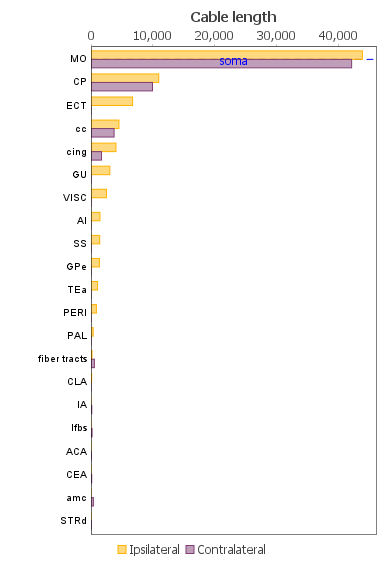

In [7]:
hist = tree_stats.getAnnotatedLengthHistogram(depth, "ratio")
annotate_soma(hist, depth)
hist.show()

# from IPython.display import Image, display
# display(Image(filename=r"./images/AA0876-annotated-length-hist-both.png",  width=500))

Much better! Now it is easier to notice that, e.g., there are no contralateral projections to the Ectorhinal area (ECT).

# Followup Questions:

1. Which kind of anatomical structures are associated with axonal processes in the ipsilateral ECT? unbranched processes? end-points? branch-points? varicosities?

2. How can we visualize the axon around that hemi-area?

We can answer all of those questions with SNT, but that would be the material for another tutorial!